# Beach Crowd Prediction — 3-Dataset Comparison

Compare model performance across three dataset strategies:
1. **Daytime only** — remove night hours (08:00–18:00), sklearn models only
2. **Full 24h** — keep all data including noisy night counts
3. **Night = 0** — keep 24h but replace night counts with 0

Sklearn models run on all 3 datasets. NeuralForecast models run on datasets 2 and 3 only (they need continuous hourly series).

In [1]:
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/dataset_comparison"

MAX_STEPS = 500
EARLY_STOP_PATIENCE = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
INPUT_SIZE = 24
MAX_GAP_HOURS = 48
MIN_SEGMENT_HOURS = 72

NIGHT_START = 20
NIGHT_END = 6

In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "xgboost", "lightgbm", "catboost", "utilsforecast"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
print("Done!")

Done!


In [3]:
import copy, json, pickle, warnings, time
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except: HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except: HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CATBOOST = True
except: HAS_CATBOOST = False

try:
    from neuralforecast import NeuralForecast
    from neuralforecast.models import (
        NHITS, NBEATSx, TFT, PatchTST, iTransformer,
        TimeMixer, TSMixerx, TCN, TiDE, MLP as NF_MLP, LSTM as NF_LSTM
    )
    from utilsforecast.preprocessing import fill_gaps as uf_fill_gaps
    HAS_NF = True
except Exception as e:
    print(f"NeuralForecast error: {e}")
    HAS_NF = False

def get_device():
    if torch.cuda.is_available():
        try:
            torch.cuda.init()
            torch.zeros(1, device='cuda')
            return 'cuda'
        except RuntimeError:
            pass
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        try:
            torch.zeros(1, device='mps')
            return 'mps'
        except RuntimeError:
            pass
    return 'cpu'

device = get_device()
NF_ACCELERATOR = {'cuda': 'gpu', 'mps': 'mps', 'cpu': 'cpu'}[device]
NF_DEVICES = 1 if device != 'cpu' else 'auto'
print(f"Device: {device}, XGB: {HAS_XGB}, LGBM: {HAS_LGBM}, CatBoost: {HAS_CATBOOST}, NF: {HAS_NF}")

2026-02-05 16:37:21,633	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


2026-02-05 16:37:21,892	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Device: cuda, XGB: True, LGBM: True, CatBoost: True, NF: True


In [4]:
def beach_metrics(y_true, y_pred, max_cap):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if max_cap == 0 or len(y_true) == 0:
        return None
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rel_mae = (mae / max_cap) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE (%)': rel_mae}

def evaluate_per_beach(df, y_pred, beach_col='beach'):
    beach_max = df.groupby(beach_col)['count'].max().to_dict()
    results = []
    for b in df[beach_col].unique():
        mask = df[beach_col] == b
        if mask.sum() < 3:
            continue
        m = beach_metrics(df.loc[mask, 'count'].values, y_pred[mask.values], beach_max.get(b, 1))
        if m:
            m['beach'] = b
            m['max_count'] = beach_max.get(b, 0)
            m['n_samples'] = mask.sum()
            results.append(m)
    return pd.DataFrame(results)

print("Metrics defined")

Metrics defined


In [5]:
def load_cache(cache_dir, model=None):
    cache_path = Path(cache_dir)
    if model:
        cache_path = cache_path / model
    records = []
    json_files = list(cache_path.rglob("*.json"))
    print(f"Found {len(json_files)} JSON files")
    for jf in json_files:
        try:
            with open(jf, 'r') as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    print(f"Loaded {len(records)} valid records")
    rows = []
    for r in records:
        row = {'filename': r.get('filename'), 'beach': r.get('beach') or r.get('name'),
               'beach_folder': r.get('beach_folder'), 'datetime': r.get('datetime'), 'count': r.get('count')}
        weather = r.get('weather', {})
        for k, v in weather.items():
            row[k] = v
        rows.append(row)
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, model=COUNTING_MODEL)

Found 169241 JSON files


Loaded 169241 valid records


In [6]:
EXCLUDE_FOLDERS = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols', 'youtube/mCxR-gnn6iA',
    'youtube/TbttHwabtfE', 'youtube/WvZWS3D1tHw', 'youtube/Z9F_jN6xpFs', 'youtube/DsrQa_tZoWw']
EXCLUDE_PREFIXES = ['ibred', 'ClubNauticSoller', 'Guenthoer']

beach_col = 'beach' if 'beach' in df_raw.columns else 'beach_folder'

before = len(df_raw)
df_raw = df_raw[~df_raw[beach_col].isin(EXCLUDE_FOLDERS)].copy()
for prefix in EXCLUDE_PREFIXES:
    df_raw = df_raw[~df_raw[beach_col].str.startswith(prefix, na=False)].copy()
print(f"Filtered cameras: {before} -> {len(df_raw)}")

Filtered cameras: 169241 -> 169241


In [7]:
def add_features(df):
    df = df.copy()
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)
    if 'om_temperature_2m' in df.columns:
        df['temp_x_summer'] = df['om_temperature_2m'] * df['is_summer']
        df['temp_x_winter'] = df['om_temperature_2m'] * (df['month'].isin([12, 1, 2])).astype(int)
    df['weekend_x_summer'] = df['is_weekend'] * df['is_summer']
    df['hour_x_summer'] = df['hour'] * df['is_summer']
    return df

df_all = add_features(df_raw)

WEATHER_FEATURES = [c for c in df_all.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_FEATURES = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night',
                     'temp_x_summer', 'temp_x_winter', 'weekend_x_summer', 'hour_x_summer']
TEMPORAL_FEATURES = [f for f in TEMPORAL_FEATURES if f in df_all.columns]
ALL_FEATURES = [f for f in WEATHER_FEATURES + TEMPORAL_FEATURES if f in df_all.columns]

df_all = df_all.dropna(subset=ALL_FEATURES + ['count']).copy()
beach_max_global = df_all.groupby(beach_col)['count'].max().to_dict()
good_beaches = [b for b, m in beach_max_global.items() if m > 20]
df_all = df_all[df_all[beach_col].isin(good_beaches)].reset_index(drop=True)

print(f"Features: {len(ALL_FEATURES)} | Beaches: {len(good_beaches)} | Samples: {len(df_all)}")
print(f"Date range: {df_all['datetime'].min()} to {df_all['datetime'].max()}")

Features: 39 | Beaches: 38 | Samples: 157384
Date range: 2022-07-14 11:00:00 to 2023-01-24 23:00:00


## Create 3 Datasets

1. **Daytime** — filter to 08:00–18:00
2. **Full 24h** — keep everything (noisy night counts)
3. **Night = 0** — keep 24h, set count=0 when hour ∈ [20:00–06:00]

In [8]:
ds_daytime = df_all[~df_all['is_night'].astype(bool)].copy().reset_index(drop=True)
ds_full24h = df_all.copy()
ds_night0 = df_all.copy()
ds_night0.loc[ds_night0['is_night'] == 1, 'count'] = 0.0

datasets = {
    'Daytime': ds_daytime,
    'Full 24h': ds_full24h,
    'Night=0': ds_night0,
}

for name, ds in datasets.items():
    night_pct = ds['is_night'].mean() * 100 if 'is_night' in ds.columns else 0
    print(f"{name:12s}: {len(ds):6d} samples | night%: {night_pct:.1f}% | mean count: {ds['count'].mean():.1f}")

Daytime     :  87492 samples | night%: 0.0% | mean count: 46.2
Full 24h    : 157384 samples | night%: 44.4% | mean count: 45.5
Night=0     : 157384 samples | night%: 44.4% | mean count: 25.7


## Dataset Analysis

Compare the three dataset strategies before training:
- **Daytime**: hours 07:00–19:00 (night hours removed)
- **Full 24h**: all hours kept with raw counts
- **Night=0**: all hours kept, counts zeroed during night window

In [ ]:
summary_rows = []
for name, ds in datasets.items():
    night_n = int(ds['is_night'].sum()) if 'is_night' in ds.columns else 0
    zeros = (ds['count'] == 0).sum()
    summary_rows.append({
        'Dataset': name,
        'Samples': len(ds),
        'Beaches': ds[beach_col].nunique(),
        'Mean': round(ds['count'].mean(), 2),
        'Median': round(ds['count'].median(), 2),
        'Std': round(ds['count'].std(), 2),
        'Max': round(ds['count'].max(), 2),
        'Zero %': round(zeros / len(ds) * 100, 1),
        'Night samples': night_n,
        'Night %': round(night_n / len(ds) * 100, 1),
    })
summary = pd.DataFrame(summary_rows).set_index('Dataset')
print(summary.to_string())

In [ ]:
beach_stats = df_all.groupby(beach_col).agg(
    samples=('count', 'size'),
    mean=('count', 'mean'),
    median=('count', 'median'),
    std=('count', 'std'),
    max=('count', 'max'),
    date_min=('datetime', 'min'),
    date_max=('datetime', 'max'),
).round(2)
beach_stats['days'] = (beach_stats['date_max'] - beach_stats['date_min']).dt.days
beach_stats = beach_stats.sort_values('samples', ascending=False)
print('Per-beach statistics (from full df_all):')
print(beach_stats.drop(columns=['date_min', 'date_max']).to_string())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bs = beach_stats.sort_values('samples', ascending=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(bs)))
axes[0].barh(bs.index, bs['samples'], color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Samples')
axes[0].set_title('Samples per Beach')
axes[0].axvline(bs['samples'].median(), color='red', ls='--', alpha=0.7, label=f"Median: {bs['samples'].median():.0f}")
axes[0].legend()

axes[1].barh(bs.index, bs['max'], color=colors, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Max Count')
axes[1].set_title('Max Crowd Count per Beach')
axes[1].axvline(bs['max'].median(), color='red', ls='--', alpha=0.7, label=f"Median: {bs['max'].median():.0f}")
axes[1].legend()

plt.suptitle('Beach Overview', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
ds_colors = {'Daytime': 'steelblue', 'Full 24h': 'coral', 'Night=0': 'seagreen'}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, (name, ds) in enumerate(datasets.items()):
    ax = axes[idx]
    ax.hist(ds['count'], bins=60, color=ds_colors[name], edgecolor='black', alpha=0.8, linewidth=0.3)
    ax.axvline(ds['count'].mean(), color='red', ls='--', label=f"Mean: {ds['count'].mean():.1f}")
    ax.axvline(ds['count'].median(), color='orange', ls='--', label=f"Median: {ds['count'].median():.1f}")
    ax.set_xlabel('Count')
    ax.set_title(f'{name} (n={len(ds)})')
    ax.legend(fontsize=8)
axes[0].set_ylabel('Frequency')
plt.suptitle('Count Distribution per Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
for name, ds in datasets.items():
    ax.hist(np.log1p(ds['count']), bins=60, alpha=0.5, label=f'{name} (n={len(ds)})', color=ds_colors[name], edgecolor='black', linewidth=0.2)
ax.set_xlabel('log(1 + count)')
ax.set_ylabel('Frequency')
ax.set_title('Log-Transformed Count Distribution — Overlaid', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
beach_order = df_all.groupby(beach_col)['count'].median().sort_values().index
for idx, (name, ds) in enumerate(datasets.items()):
    ax = axes[idx]
    data = [ds[ds[beach_col] == b]['count'].values for b in beach_order]
    bp = ax.boxplot(data, vert=True, patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor(ds_colors[name])
        patch.set_alpha(0.6)
    ax.set_xticklabels(beach_order, rotation=45, ha='right', fontsize=7)
    ax.set_title(name)
axes[0].set_ylabel('Count')
plt.suptitle('Count Distribution per Beach — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
for idx, (name, ds) in enumerate(datasets.items()):
    ax = axes[idx]
    h = ds.groupby('hour')['count'].agg(['mean', 'std'])
    ax.fill_between(h.index, h['mean'] - h['std'], h['mean'] + h['std'], alpha=0.15, color=ds_colors[name])
    ax.plot(h.index, h['mean'], 'o-', color=ds_colors[name], markersize=4)
    ax.axvspan(NIGHT_START, 23, alpha=0.07, color='gray')
    ax.axvspan(0, NIGHT_END, alpha=0.07, color='gray')
    ax.set_xlabel('Hour')
    ax.set_title(name)

ax = axes[3]
for name, ds in datasets.items():
    h = ds.groupby('hour')['count'].mean()
    ax.plot(h.index, h.values, 'o-', label=name, color=ds_colors[name], linewidth=2, markersize=4)
ax.axvspan(NIGHT_START, 23, alpha=0.07, color='gray', label='Night')
ax.axvspan(0, NIGHT_END, alpha=0.07, color='gray')
ax.set_xlabel('Hour')
ax.set_title('Overlaid')
ax.legend(fontsize=8)

axes[0].set_ylabel('Mean Count')
plt.suptitle('Hourly Patterns (gray = night window)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for name, ds in datasets.items():
    daily = ds.groupby('day_of_week')['count'].mean()
    axes[0].plot(daily.index, daily.values, 'o-', label=name, color=ds_colors[name], linewidth=2)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(dow_labels)
axes[0].set_ylabel('Mean Count')
axes[0].set_title('Day of Week')
axes[0].legend()

x = np.arange(2)
w = 0.25
for i, (name, ds) in enumerate(datasets.items()):
    we = ds.groupby('is_weekend')['count'].mean()
    axes[1].bar(x + i * w, we.values, width=w, label=name, color=ds_colors[name], edgecolor='black', linewidth=0.3)
axes[1].set_xticks(x + w)
axes[1].set_xticklabels(['Weekday', 'Weekend'])
axes[1].set_ylabel('Mean Count')
axes[1].set_title('Weekend vs Weekday')
axes[1].legend()

plt.suptitle('Weekly Patterns — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, ds in datasets.items():
    m = ds.groupby('month')['count'].mean()
    axes[0].plot(m.index, m.values, 'o-', label=name, color=ds_colors[name], linewidth=2)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Mean Count')
axes[0].set_title('Monthly Mean Count')
axes[0].legend()

for name, ds in datasets.items():
    m = ds.groupby('month').size()
    axes[1].plot(m.index, m.values, 'o-', label=name, color=ds_colors[name], linewidth=2)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Samples')
axes[1].set_title('Samples per Month')
axes[1].legend()

plt.suptitle('Monthly Patterns — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
for idx, (name, ds) in enumerate(datasets.items()):
    piv = ds.groupby([beach_col, 'hour'])['count'].mean().unstack(fill_value=0)
    piv_n = piv.div(piv.max(axis=1).replace(0, 1), axis=0)
    ax = axes[idx]
    im = ax.imshow(piv_n.values, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
    ax.set_yticks(range(len(piv_n.index)))
    ax.set_yticklabels(piv_n.index, fontsize=7)
    ax.set_xticks(range(len(piv_n.columns)))
    ax.set_xticklabels(piv_n.columns, fontsize=8)
    ax.set_xlabel('Hour')
    ax.set_title(name)
    if idx == 0:
        ax.set_ylabel('Beach')
plt.colorbar(im, ax=axes, label='Relative occupancy', shrink=0.6)
plt.suptitle('Normalized Hourly Occupancy per Beach — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
weather_cols = [f for f in WEATHER_FEATURES if f in df_all.columns]
if weather_cols:
    fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
    for idx, (name, ds) in enumerate(datasets.items()):
        corr = ds[weather_cols + ['count']].corr()['count'].drop('count').sort_values()
        top = pd.concat([corr.head(6), corr.tail(6)]).drop_duplicates()
        ax = axes[idx]
        colors = ['#d32f2f' if v < 0 else '#1976d2' for v in top.values]
        ax.barh(top.index, top.values, color=colors, edgecolor='black', linewidth=0.3)
        ax.axvline(0, color='black', linewidth=0.5)
        ax.set_title(name)
    axes[0].set_ylabel('Weather Feature')
    axes[1].set_xlabel('Correlation with count')
    plt.suptitle('Top Weather Correlations — by Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
print('Feature correlations with count — per dataset:\n')
corr_df = pd.DataFrame()
for name, ds in datasets.items():
    c = ds[ALL_FEATURES + ['count']].corr()['count'].drop('count')
    corr_df[name] = c
corr_df['abs_avg'] = corr_df.abs().mean(axis=1)
corr_df = corr_df.sort_values('abs_avg', ascending=False)
print(corr_df.round(3).to_string())

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
for idx, (name, ds) in enumerate(datasets.items()):
    ax = axes[idx]
    daily = ds.set_index('datetime')['count'].resample('D').mean()
    ax.plot(daily.index, daily.values, color=ds_colors[name], linewidth=1, alpha=0.8)
    ax.fill_between(daily.index, 0, daily.values, alpha=0.15, color=ds_colors[name])
    ax.set_ylabel('Daily Avg')
    ax.set_title(f'{name}')
plt.suptitle('Daily Average Count — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

night_mask = df_all['is_night'].astype(bool)
day_mask = ~night_mask

axes[0].scatter(ds_full24h.loc[day_mask, 'count'], ds_night0.loc[day_mask, 'count'], s=3, alpha=0.3, color='steelblue', label='Day hours')
axes[0].scatter(ds_full24h.loc[night_mask, 'count'], ds_night0.loc[night_mask, 'count'], s=3, alpha=0.3, color='coral', label='Night hours')
mx = max(ds_full24h['count'].max(), ds_night0['count'].max())
axes[0].plot([0, mx], [0, mx], 'k--', alpha=0.3)
axes[0].set_xlabel('Full 24h count')
axes[0].set_ylabel('Night=0 count')
axes[0].set_title('Full 24h vs Night=0')
axes[0].legend(markerscale=4)

night_counts = ds_full24h[night_mask]['count']
axes[1].hist(night_counts, bins=50, color='coral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Night Counts in Full 24h (n={len(night_counts)}, mean={night_counts.mean():.1f})')

plt.suptitle('Night Impact Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
beach_order = df_all.groupby(beach_col)['count'].median().sort_values().index
x = np.arange(len(beach_order))
w = 0.25
for i, (name, ds) in enumerate(datasets.items()):
    counts = ds.groupby(beach_col).size().reindex(beach_order, fill_value=0)
    ax.bar(x + i * w, counts.values, width=w, label=name, color=ds_colors[name], edgecolor='black', linewidth=0.3)
ax.set_xticks(x + w)
ax.set_xticklabels(beach_order, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Samples')
ax.set_title('Samples per Beach — by Dataset', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
top6 = beach_stats.head(6).index.tolist()
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
for idx, beach in enumerate(top6):
    ax = axes[idx // 2, idx % 2]
    for name, ds in datasets.items():
        bdata = ds[ds[beach_col] == beach].set_index('datetime')['count'].resample('D').mean()
        ax.plot(bdata.index, bdata.values, label=name, color=ds_colors[name], linewidth=1, alpha=0.8)
    ax.set_ylabel('Daily Avg')
    ax.set_title(beach, fontsize=10, fontweight='bold')
    if idx == 0:
        ax.legend(fontsize=8)
plt.suptitle('Daily Avg — Top 6 Beaches — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
for idx, (name, ds) in enumerate(datasets.items()):
    ax = axes[idx]
    n = len(ds)
    t1, t2 = int(n * 0.7), int(n * 0.85)
    d_min, d_t1, d_t2, d_max = ds['datetime'].iloc[0], ds['datetime'].iloc[t1], ds['datetime'].iloc[t2], ds['datetime'].iloc[-1]
    ax.axvspan(d_min, d_t1, alpha=0.2, color='steelblue', label=f'Train ({t1})')
    ax.axvspan(d_t1, d_t2, alpha=0.2, color='orange', label=f'Val ({t2-t1})')
    ax.axvspan(d_t2, d_max, alpha=0.2, color='coral', label=f'Test ({n-t2})')
    daily = ds.set_index('datetime')['count'].resample('D').mean()
    ax.plot(daily.index, daily.values, color='black', linewidth=0.7, alpha=0.6)
    ax.set_ylabel('Daily Avg')
    ax.set_title(name)
    ax.legend(fontsize=7, loc='upper right')
plt.suptitle('Train / Val / Test Split — by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
missing = df_raw[ALL_FEATURES + ['count']].isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({'missing': missing, 'pct (%)': missing_pct})
missing_df = missing_df[missing_df['missing'] > 0].sort_values('pct (%)', ascending=False)
if len(missing_df) > 0:
    print(f'Features with missing values ({len(missing_df)}/{len(ALL_FEATURES)+1}):')
    print(missing_df.head(15).to_string())
    print(f'\nRaw samples: {len(df_raw)} → Clean: {len(df_all)} (dropped {len(df_raw)-len(df_all)}, {(len(df_raw)-len(df_all))/len(df_raw)*100:.1f}%)')
else:
    print('No missing values in features or target')

In [9]:
def compute_sample_weights(df, beach_col='beach'):
    beach_max = df.groupby(beach_col)['count'].max()
    weights = df[beach_col].map(beach_max)
    weights = 1.0 / weights.replace(0, 1)
    weights = weights / weights.mean()
    return weights.values

def split_data(df, features, train_frac=0.7, val_frac=0.15):
    X = df[features]
    y = df['count']
    n = len(X)
    t1, t2 = int(n * train_frac), int(n * (train_frac + val_frac))

    trainval = df.iloc[:t2]
    w = compute_sample_weights(trainval, beach_col)
    w_full = np.zeros(n)
    w_full[:t2] = w

    return {
        'X_train': X.iloc[:t1], 'X_val': X.iloc[t1:t2], 'X_test': X.iloc[t2:],
        'y_train': y.iloc[:t1], 'y_val': y.iloc[t1:t2], 'y_test': y.iloc[t2:],
        'df_train': df.iloc[:t1], 'df_val': df.iloc[t1:t2], 'df_test': df.iloc[t2:],
        'w_trainval': w,
    }

splits = {}
for name, ds in datasets.items():
    splits[name] = split_data(ds, ALL_FEATURES)
    s = splits[name]
    print(f"{name:12s}: train={len(s['X_train'])}, val={len(s['X_val'])}, test={len(s['X_test'])}, weights range=[{s['w_trainval'].min():.3f}, {s['w_trainval'].max():.3f}]")


Daytime     : train=61244, val=13124, test=13124
Full 24h    : train=110168, val=23608, test=23608
Night=0     : train=110168, val=23608, test=23608


## Sklearn Models — All 3 Datasets (Weighted by 1/max_count per beach)

Training uses sample weights = 1/max_count per beach, so models optimize for relative MAE across beaches equally.


In [10]:
def get_sklearn_models():
    models = {
        'Lasso': Lasso(alpha=0.1),
        'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=8, random_state=42),
    }
    if HAS_XGB:
        models['XGBoost'] = XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1, verbosity=0)
    if HAS_LGBM:
        models['LightGBM'] = LGBMRegressor(n_estimators=300, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
    if HAS_CATBOOST:
        models['CatBoost'] = CatBoostRegressor(n_estimators=300, max_depth=8, learning_rate=0.1, random_state=42, verbose=0)
    return models

print(f"Sklearn models: {list(get_sklearn_models().keys())}")

Sklearn models: ['Lasso', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost']


In [11]:
all_results = []
all_beach_results = []

for ds_name, ds in datasets.items():
    s = splits[ds_name]
    X_trainval = pd.concat([s['X_train'], s['X_val']])
    y_trainval = pd.concat([s['y_train'], s['y_val']])
    w_trainval = s['w_trainval']

    print(f"\n{'='*70}")
    print(f"SKLEARN — {ds_name} ({len(s['X_test'])} test samples) [weighted training]")
    print(f"{'='*70}")

    for model_name, model in get_sklearn_models().items():
        start = time.time()
        model.fit(X_trainval, y_trainval, sample_weight=w_trainval)
        train_time = time.time() - start

        y_pred = np.clip(model.predict(s['X_test']), 0, None)
        y_true = s['y_test'].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        beach_df = evaluate_per_beach(s['df_test'], y_pred, beach_col)
        beach_df['model'] = model_name
        beach_df['dataset'] = ds_name
        beach_df['model_type'] = 'Sklearn'
        all_beach_results.append(beach_df)

        avg_rel_mae = beach_df['RelMAE (%)'].mean()

        all_results.append({
            'Model': model_name, 'Dataset': ds_name, 'Type': 'Sklearn',
            'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Avg RelMAE (%)': avg_rel_mae,
            'Time (s)': train_time, 'N_test': len(y_true)
        })
        print(f"  {model_name:20s} | {train_time:5.1f}s | MAE: {mae:7.2f} | RelMAE: {avg_rel_mae:6.2f}% | R2: {r2:.4f}")

print(f"\nSklearn done: {len(all_results)} results")



SKLEARN — Daytime (13124 test samples)


  Lasso                |   2.1s | MAE:   51.30 | RelMAE: 122.27% | R2: -0.1740


  RandomForest         |  11.3s | MAE:   39.80 | RelMAE:  83.03% | R2: 0.0133


  GradientBoosting     | 252.8s | MAE:   68.66 | RelMAE: 182.68% | R2: -1.1606


  XGBoost              |   2.1s | MAE:   42.64 | RelMAE:  92.12% | R2: -0.0762


  LightGBM             |   1.5s | MAE:   33.04 | RelMAE:  59.55% | R2: 0.1293


  CatBoost             |   2.8s | MAE:   32.22 | RelMAE:  60.97% | R2: 0.1290

SKLEARN — Full 24h (23608 test samples)


  Lasso                |   2.6s | MAE:   46.91 | RelMAE: 100.28% | R2: -0.0382


  RandomForest         |  20.1s | MAE:   40.41 | RelMAE:  85.04% | R2: 0.0606


  GradientBoosting     | 447.5s | MAE:   62.45 | RelMAE: 157.83% | R2: -0.6408


  XGBoost              |   2.4s | MAE:   54.26 | RelMAE: 132.00% | R2: -0.3579


  LightGBM             |   2.1s | MAE:   35.04 | RelMAE:  67.25% | R2: 0.1514


  CatBoost             |   4.4s | MAE:   33.57 | RelMAE:  60.95% | R2: 0.1671

SKLEARN — Night=0 (23608 test samples)


  Lasso                |   3.3s | MAE:   26.49 | RelMAE:  55.61% | R2: 0.1623


  RandomForest         |  12.5s | MAE:   21.89 | RelMAE:  45.06% | R2: 0.2024


  GradientBoosting     | 426.7s | MAE:   31.45 | RelMAE:  72.89% | R2: -0.1778


  XGBoost              |   2.1s | MAE:   29.17 | RelMAE:  68.05% | R2: 0.0074


  LightGBM             |   2.1s | MAE:   19.42 | RelMAE:  37.46% | R2: 0.2655


  CatBoost             |   4.5s | MAE:   18.74 | RelMAE:  34.93% | R2: 0.2779

Sklearn done: 18 results


## NeuralForecast Models — Full 24h and Night=0 Only

Daytime dataset has 14h gaps every night — NF models need continuous hourly series.

In [12]:
def to_nf_format(df, features, target='count', id_col='beach'):
    nf_df = df[['datetime', id_col, target] + features].copy()
    nf_df = nf_df.rename(columns={'datetime': 'ds', id_col: 'unique_id', target: 'y'})
    return nf_df

def split_at_long_gaps(nf_df, max_gap_hours=MAX_GAP_HOURS, min_segment_hours=MIN_SEGMENT_HOURS):
    result = []
    for uid in nf_df['unique_id'].unique():
        s = nf_df[nf_df['unique_id'] == uid].sort_values('ds').copy()
        gaps = s['ds'].diff().dt.total_seconds() / 3600
        split_points = gaps[gaps > max_gap_hours].index.tolist()

        segments = []
        prev = s.index[0]
        for sp in split_points:
            segments.append(s.loc[prev:s.index[s.index.get_loc(sp) - 1]])
            prev = sp
        segments.append(s.loc[prev:])

        for i, seg in enumerate(segments):
            if len(seg) >= min_segment_hours:
                seg = seg.copy()
                seg['unique_id'] = f"{uid}__seg{i}" if len(segments) > 1 else uid
                result.append(seg)
    return pd.concat(result, ignore_index=True)

def prepare_nf_data(ds_name):
    s = splits[ds_name]
    trainval = pd.concat([s['df_train'], s['df_val']])
    nf_trainval = to_nf_format(trainval, ALL_FEATURES, id_col=beach_col)
    nf_test = to_nf_format(s['df_test'], ALL_FEATURES, id_col=beach_col)

    nf_trainval = split_at_long_gaps(nf_trainval)
    nf_test = split_at_long_gaps(nf_test)

    nf_trainval = nf_trainval.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
    nf_test = nf_test.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()

    nf_trainval = uf_fill_gaps(nf_trainval, freq='h')
    nf_test = uf_fill_gaps(nf_test, freq='h')

    for col in ['y'] + ALL_FEATURES:
        if col in nf_trainval.columns:
            nf_trainval[col] = nf_trainval.groupby('unique_id')[col].ffill().bfill()
        if col in nf_test.columns:
            nf_test[col] = nf_test.groupby('unique_id')[col].ffill().bfill()

    common = set(nf_trainval['unique_id'].unique()) & set(nf_test['unique_id'].unique())
    nf_trainval = nf_trainval[nf_trainval['unique_id'].isin(common)]
    nf_test = nf_test[nf_test['unique_id'].isin(common)]

    return nf_trainval, nf_test, len(common)

nf_datasets = {}
for ds_name in ['Full 24h', 'Night=0']:
    tv, te, ns = prepare_nf_data(ds_name)
    nf_datasets[ds_name] = {'trainval': tv, 'test': te, 'n_series': ns}
    print(f"{ds_name}: train+val={len(tv)}, test={len(te)}, series={ns}")

Full 24h: train+val=86449, test=16172, series=22


Night=0: train+val=86449, test=16172, series=22


In [13]:
def get_nf_models(n_series, hist_exog):
    common = dict(
        h=1, input_size=INPUT_SIZE, max_steps=MAX_STEPS,
        early_stop_patience_steps=EARLY_STOP_PATIENCE, scaler_type='robust',
        learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,
        val_check_steps=50, random_seed=42, start_padding_enabled=True,
        accelerator=NF_ACCELERATOR, devices=NF_DEVICES,
    )
    return [
        ('LSTM', NF_LSTM(hist_exog_list=hist_exog, encoder_n_layers=2, encoder_hidden_size=128, decoder_hidden_size=128, decoder_layers=2, **common)),
        ('NHITS', NHITS(hist_exog_list=hist_exog, **common)),
        ('NBEATSx', NBEATSx(hist_exog_list=hist_exog, stack_types=['identity', 'identity', 'identity'], **common)),
        ('TFT', TFT(hist_exog_list=hist_exog, hidden_size=64, **common)),
        ('TCN', TCN(hist_exog_list=hist_exog, **common)),
        ('TiDE', TiDE(hist_exog_list=hist_exog, **common)),
        ('NF_MLP', NF_MLP(hist_exog_list=hist_exog, **common)),
        ('PatchTST', PatchTST(**common)),
        ('TimeMixer', TimeMixer(n_series=n_series, **common)),
        ('TSMixerx', TSMixerx(n_series=n_series, **common)),
        ('iTransformer', iTransformer(n_series=n_series, **common)),
    ]

if HAS_NF:
    for ds_name, nf_data in nf_datasets.items():
        tv, te, ns = nf_data['trainval'], nf_data['test'], nf_data['n_series']
        min_len = tv.groupby('unique_id').size().min()
        val_size = max(24, min(min_len // 5, 200))

        print(f"\n{'='*70}")
        print(f"NEURALFORECAST — {ds_name} (series={ns}, val_size={val_size})")
        print(f"{'='*70}")

        for model_name, model in get_nf_models(ns, ALL_FEATURES):
            print(f"\n  {model_name}...")
            try:
                start = time.time()
                nf = NeuralForecast(models=[model], freq='h')
                nf.fit(df=tv, val_size=val_size)
                train_time = time.time() - start

                preds = nf.predict(df=tv).reset_index()
                pred_col = [c for c in preds.columns if c not in ['unique_id', 'ds']][0]
                merged = te.merge(preds[['unique_id', 'ds', pred_col]], on=['unique_id', 'ds'], how='inner')

                if len(merged) == 0:
                    raise ValueError("No matching predictions")

                y_pred = np.clip(merged[pred_col].values, 0, None)
                y_true = merged['y'].values

                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                r2 = r2_score(y_true, y_pred)

                eval_df = merged.rename(columns={'unique_id': beach_col, 'y': 'count'}).copy()
                beach_df = evaluate_per_beach(eval_df, y_pred, beach_col)
                beach_df['model'] = model_name
                beach_df['dataset'] = ds_name
                beach_df['model_type'] = 'NeuralForecast'
                all_beach_results.append(beach_df)

                avg_rel_mae = beach_df['RelMAE (%)'].mean()
                all_results.append({
                    'Model': model_name, 'Dataset': ds_name, 'Type': 'NeuralForecast',
                    'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Avg RelMAE (%)': avg_rel_mae,
                    'Time (s)': train_time, 'N_test': len(merged)
                })
                print(f"    {train_time:.1f}s | MAE: {mae:.2f} | RelMAE: {avg_rel_mae:.2f}% | R2: {r2:.4f} | matched: {len(merged)}/{len(te)}")

            except Exception as e:
                print(f"    ERROR: {e}")
                all_results.append({
                    'Model': model_name, 'Dataset': ds_name, 'Type': 'NeuralForecast',
                    'MAE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'Avg RelMAE (%)': np.nan,
                    'Time (s)': np.nan, 'N_test': 0
                })

Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42



NEURALFORECAST — Full 24h (series=22, val_size=200)

  LSTM...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


W0205 16:57:41.913000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149238 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:42.211000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149286 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:42.542000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149334 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:42.909000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149382 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:43.311000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149433 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:43.636000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149481 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:43.969000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149529 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:44.363000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149556 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 1 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:44.640000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149628 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:44.976000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149676 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:45.339000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149724 via signal SIGTERM


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


W0205 16:57:45.909000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149775 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:46.294000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149823 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:47.140000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149922 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:47.498000 145276 torch/multiprocessing/spawn.py:165] Terminating process 149970 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:48.054000 145276 torch/multiprocessing/spawn.py:165] Terminating process 150021 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:48.345000 145276 torch/multiprocessing/spawn.py:165] Terminating process 150069 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:48.692000 145276 torch/multiprocessing/spawn.py:165] Terminating process 150117 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:49.068000 145276 torch/multiprocessing/spawn.py:165] Terminating process 150168 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:49.451000 145276 torch/multiprocessing/spawn.py:165] Terminating process 150216 via signal SIGTERM


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

W0205 16:57:49.796000 145276 torch/multiprocessing/spawn.py:165] Terminating process 150264 via signal SIGTERM


    ERROR: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/gmossi/.local/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 87, in _wrap
    fn(i, *args)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1033, in _run
    self.strategy.setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/ddp.py", line 154, in setup_environment
    super().setup_environment()
  File "/home/gmossi/.local/lib/python3.10/site-packages/pytorch_lightning/strategies/str

## Results

In [14]:
results_df = pd.DataFrame(all_results).sort_values(['Dataset', 'Avg RelMAE (%)'])
beach_results_df = pd.concat(all_beach_results, ignore_index=True)

save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)
results_df.to_csv(save_dir / 'results_comparison.csv', index=False)
beach_results_df.to_csv(save_dir / 'beach_results_comparison.csv', index=False)

for ds_name in datasets.keys():
    sub = results_df[results_df['Dataset'] == ds_name].copy()
    print(f"\n{'='*80}")
    print(f"  {ds_name}")
    print(f"{'='*80}")
    print(sub[['Model', 'Type', 'MAE', 'RMSE', 'R2', 'Avg RelMAE (%)', 'Time (s)']].to_string(index=False))


  Daytime
           Model    Type       MAE      RMSE        R2  Avg RelMAE (%)   Time (s)
        LightGBM Sklearn 33.037074 55.635207  0.129325       59.550866   1.505194
        CatBoost Sklearn 32.223264 55.647106  0.128953       60.969763   2.804268
    RandomForest Sklearn 39.799239 59.227536  0.013257       83.030579  11.272808
         XGBoost Sklearn 42.644495 61.855064 -0.076235       92.115357   2.090675
           Lasso Sklearn 51.302442 64.602485 -0.173964      122.274116   2.112288
GradientBoosting Sklearn 68.661748 87.642154 -1.160641      182.680798 252.808110

  Full 24h
           Model           Type       MAE      RMSE        R2  Avg RelMAE (%)   Time (s)
        CatBoost        Sklearn 33.568882 56.437771  0.167101       60.949883   4.428112
        LightGBM        Sklearn 35.041769 56.967614  0.151389       67.245495   2.078387
    RandomForest        Sklearn 40.414996 59.938035  0.060584       85.042029  20.084247
           Lasso        Sklearn 46.912981 63.01

In [15]:
pivot = results_df.pivot_table(index='Model', columns='Dataset', values='Avg RelMAE (%)', aggfunc='first')
pivot = pivot.sort_values(pivot.columns[0], na_position='last')
print("\nRelMAE (%) — Model × Dataset:")
print(pivot.round(2).to_string())


RelMAE (%) — Model × Dataset:
Dataset           Daytime  Full 24h  Night=0
Model                                       
LightGBM            59.55     67.25    37.46
CatBoost            60.97     60.95    34.93
RandomForest        83.03     85.04    45.06
XGBoost             92.12    132.00    68.05
Lasso              122.27    100.28    55.61
GradientBoosting   182.68    157.83    72.89


## Visualizations

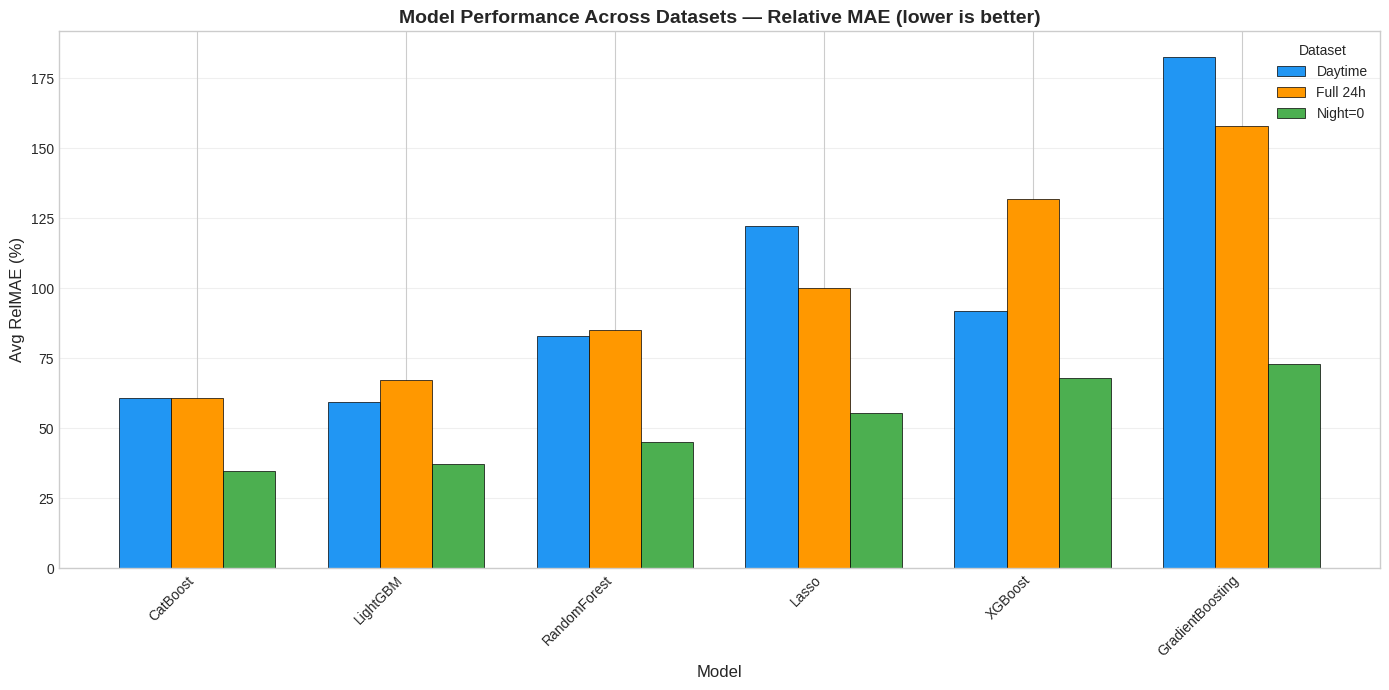

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))

pivot_plot = results_df.pivot_table(index='Model', columns='Dataset', values='Avg RelMAE (%)', aggfunc='first')
models_sorted = pivot_plot.mean(axis=1).sort_values().index
pivot_plot = pivot_plot.loc[models_sorted]

x = np.arange(len(pivot_plot))
width = 0.25
ds_names = list(datasets.keys())
colors = ['#2196F3', '#FF9800', '#4CAF50']

for i, ds in enumerate(ds_names):
    if ds in pivot_plot.columns:
        vals = pivot_plot[ds].values
        bars = ax.bar(x + i * width, vals, width, label=ds, color=colors[i], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Avg RelMAE (%)', fontsize=12)
ax.set_title('Model Performance Across Datasets — Relative MAE (lower is better)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(pivot_plot.index, rotation=45, ha='right')
ax.legend(title='Dataset')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(save_dir / 'grouped_bar_relmae.png', dpi=150, bbox_inches='tight')
plt.show()

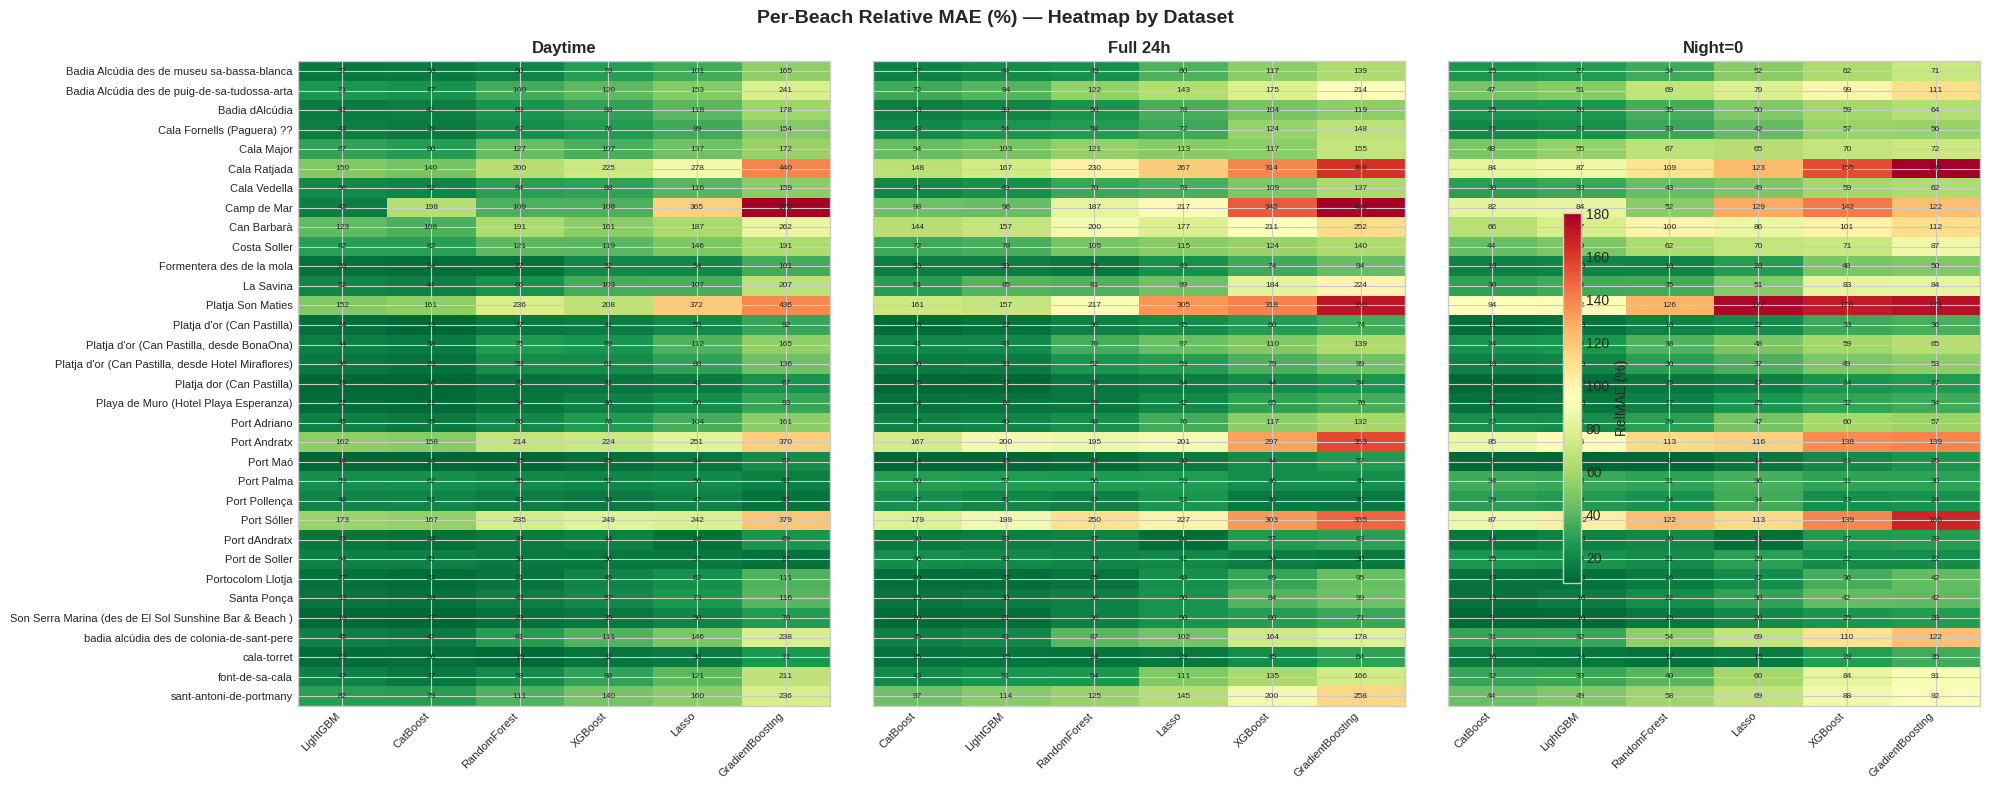

In [17]:
fig, axes = plt.subplots(1, len(datasets), figsize=(22, 10), sharey=True)

vmin = beach_results_df['RelMAE (%)'].quantile(0.05)
vmax = beach_results_df['RelMAE (%)'].quantile(0.95)

for idx, ds_name in enumerate(datasets.keys()):
    sub = beach_results_df[beach_results_df['dataset'] == ds_name]
    if len(sub) == 0:
        axes[idx].set_title(f'{ds_name}\n(no results)')
        continue

    heatmap_data = sub.pivot_table(index='beach', columns='model', values='RelMAE (%)', aggfunc='first')
    beach_order = heatmap_data.mean(axis=1).sort_values().index
    model_order = heatmap_data.mean().sort_values().index
    heatmap_data = heatmap_data.loc[beach_order, model_order]

    im = axes[idx].imshow(heatmap_data.values, cmap='RdYlGn_r', aspect='auto', vmin=vmin, vmax=vmax)
    axes[idx].set_xticks(range(len(heatmap_data.columns)))
    axes[idx].set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=8)
    if idx == 0:
        axes[idx].set_yticks(range(len(heatmap_data.index)))
        axes[idx].set_yticklabels(heatmap_data.index, fontsize=7)
    axes[idx].set_title(f'{ds_name}', fontsize=12, fontweight='bold')

    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            val = heatmap_data.values[i, j]
            if not np.isnan(val):
                color = 'white' if val > (vmax + vmin) / 2 else 'black'
                axes[idx].text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=5, color=color)

    col_means = heatmap_data.mean()
    axes[idx].set_xlabel('\n' + '  |  '.join([f'{m}: {v:.1f}%' for m, v in col_means.items()]), fontsize=6)

fig.colorbar(im, ax=axes, label='Prediction RelMAE (%)', shrink=0.6, pad=0.02)
fig.suptitle('Prediction Relative MAE (%) per Beach — Weighted Training (lower = better)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(save_dir / 'beach_relmae_heatmap_weighted.png', dpi=150, bbox_inches='tight')
plt.show()


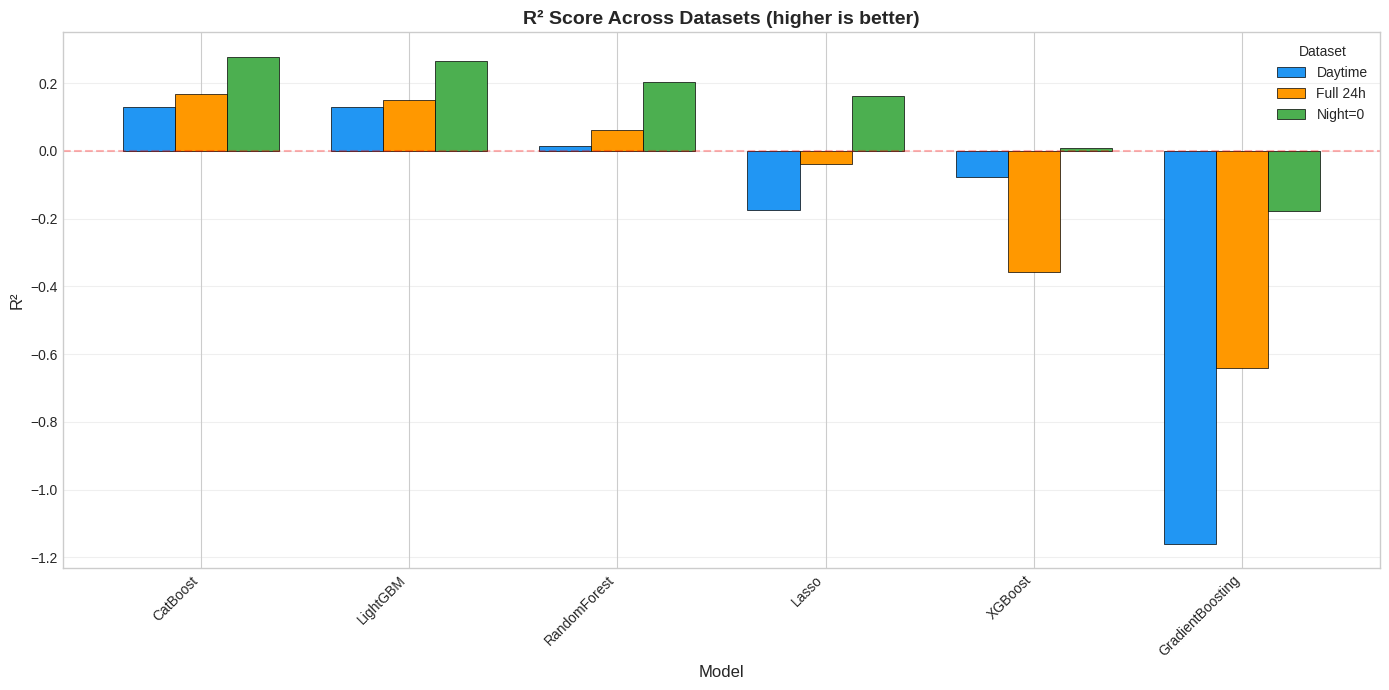

In [18]:
fig, ax = plt.subplots(figsize=(14, 7))

pivot_r2 = results_df.pivot_table(index='Model', columns='Dataset', values='R2', aggfunc='first')
pivot_r2 = pivot_r2.loc[models_sorted]

x = np.arange(len(pivot_r2))
for i, ds in enumerate(ds_names):
    if ds in pivot_r2.columns:
        vals = pivot_r2[ds].values
        ax.bar(x + i * width, vals, width, label=ds, color=colors[i], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('R² Score Across Datasets (higher is better)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(pivot_r2.index, rotation=45, ha='right')
ax.legend(title='Dataset')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(save_dir / 'grouped_bar_r2.png', dpi=150, bbox_inches='tight')
plt.show()

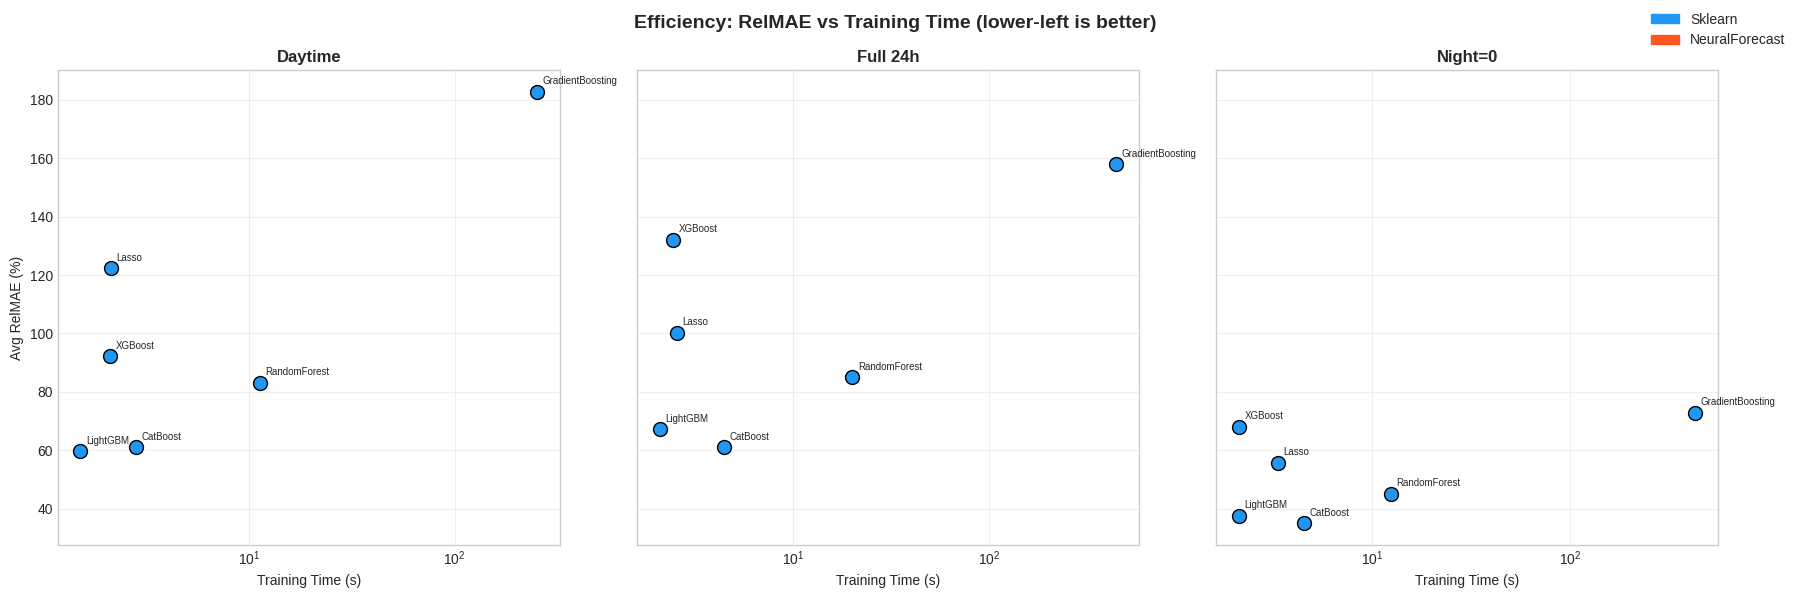

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, ds_name in enumerate(datasets.keys()):
    sub = results_df[results_df['Dataset'] == ds_name].dropna()
    ax = axes[idx]
    for _, row in sub.iterrows():
        c = '#2196F3' if row['Type'] == 'Sklearn' else '#FF5722'
        ax.scatter(row['Time (s)'], row['Avg RelMAE (%)'], s=100, c=c, edgecolor='black', zorder=5)
        ax.annotate(row['Model'], (row['Time (s)'], row['Avg RelMAE (%)']),
                   fontsize=7, ha='left', va='bottom', xytext=(4, 4), textcoords='offset points')
    ax.set_xlabel('Training Time (s)')
    ax.set_title(f'{ds_name}', fontweight='bold')
    ax.set_xscale('log')
    ax.grid(alpha=0.3)

axes[0].set_ylabel('Avg RelMAE (%)')

from matplotlib.patches import Patch
fig.legend(handles=[Patch(color='#2196F3', label='Sklearn'), Patch(color='#FF5722', label='NeuralForecast')],
           loc='upper right', fontsize=10)
fig.suptitle('Efficiency: RelMAE vs Training Time (lower-left is better)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(save_dir / 'efficiency_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

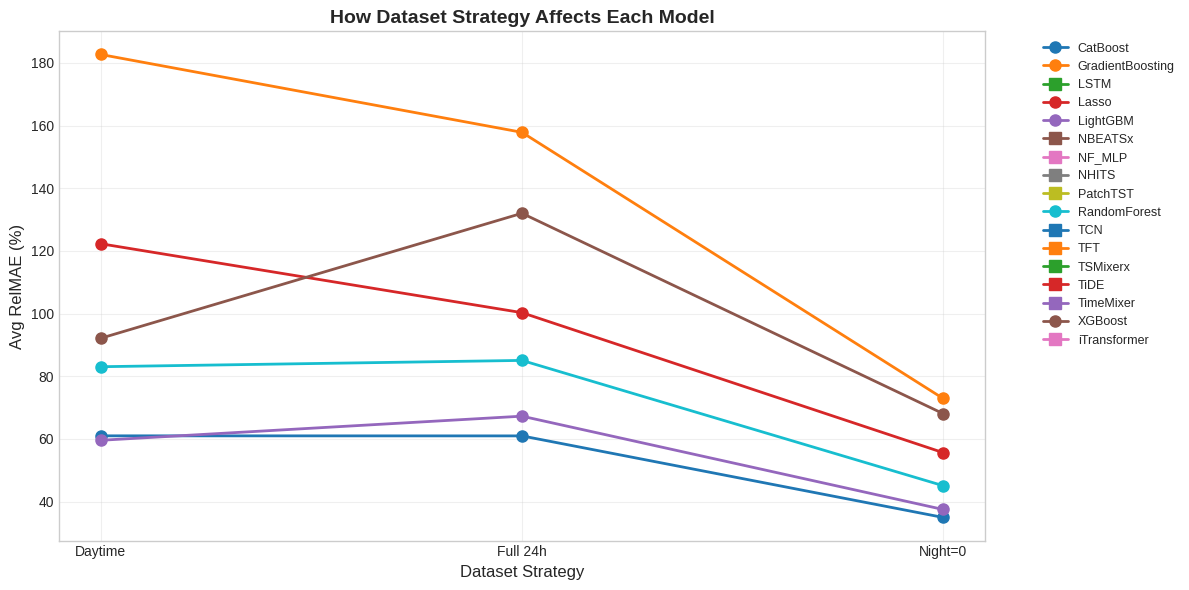

In [20]:
models_both = results_df.groupby('Model').filter(lambda x: len(x) >= 2)['Model'].unique()
fig, ax = plt.subplots(figsize=(12, 6))

for model_name in sorted(models_both):
    sub = results_df[results_df['Model'] == model_name].sort_values('Dataset')
    marker = 'o' if sub['Type'].iloc[0] == 'Sklearn' else 's'
    ax.plot(sub['Dataset'], sub['Avg RelMAE (%)'], marker=marker, label=model_name, linewidth=2, markersize=8)

ax.set_xlabel('Dataset Strategy', fontsize=12)
ax.set_ylabel('Avg RelMAE (%)', fontsize=12)
ax.set_title('How Dataset Strategy Affects Each Model', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(save_dir / 'dataset_impact.png', dpi=150, bbox_inches='tight')
plt.show()

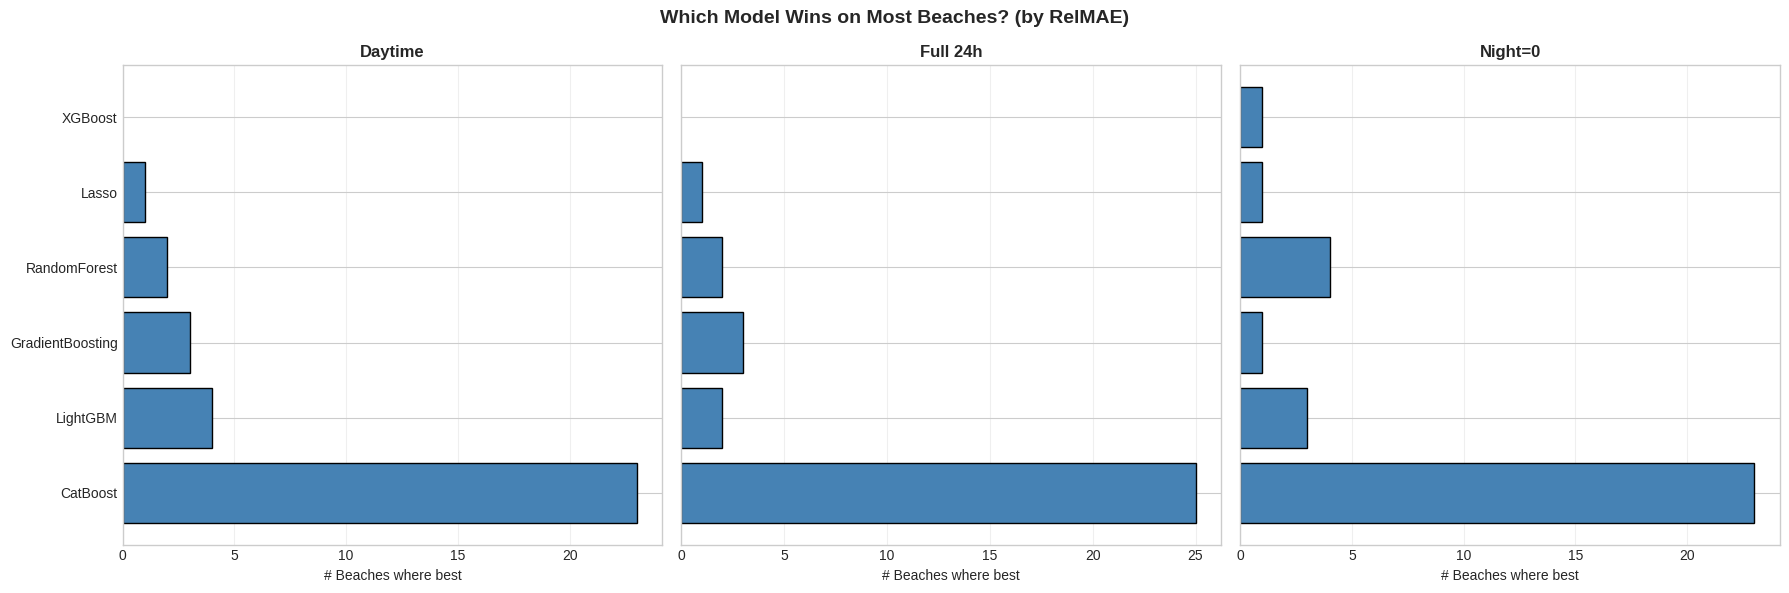

In [21]:
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 6), sharey=True)

for idx, ds_name in enumerate(datasets.keys()):
    sub = beach_results_df[beach_results_df['dataset'] == ds_name]
    if len(sub) == 0:
        continue
    best_per_beach = sub.loc[sub.groupby('beach')['RelMAE (%)'].idxmin()]
    counts = best_per_beach['model'].value_counts()

    axes[idx].barh(counts.index, counts.values, color='steelblue', edgecolor='black')
    axes[idx].set_xlabel('# Beaches where best')
    axes[idx].set_title(f'{ds_name}', fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

fig.suptitle('Which Model Wins on Most Beaches? (by RelMAE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(save_dir / 'best_per_beach.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

for ds_name in datasets.keys():
    sub = results_df[results_df['Dataset'] == ds_name].dropna()
    if len(sub) == 0:
        continue
    best = sub.loc[sub['Avg RelMAE (%)'].idxmin()]
    print(f"\n{ds_name}:")
    print(f"  Best: {best['Model']} ({best['Type']}) — RelMAE: {best['Avg RelMAE (%)']:.2f}%, R2: {best['R2']:.4f}")
    sk = sub[sub['Type'] == 'Sklearn']
    if len(sk) > 0:
        best_sk = sk.loc[sk['Avg RelMAE (%)'].idxmin()]
        print(f"  Best Sklearn: {best_sk['Model']} — RelMAE: {best_sk['Avg RelMAE (%)']:.2f}%")
    nf = sub[sub['Type'] == 'NeuralForecast']
    if len(nf) > 0:
        best_nf = nf.loc[nf['Avg RelMAE (%)'].idxmin()]
        print(f"  Best NF: {best_nf['Model']} — RelMAE: {best_nf['Avg RelMAE (%)']:.2f}%")

print(f"\nTotal results: {len(results_df)}")
print(f"Beach-level results: {len(beach_results_df)}")
print(f"Saved to: {save_dir}")


SUMMARY

Daytime:
  Best: LightGBM (Sklearn) — RelMAE: 59.55%, R2: 0.1293
  Best Sklearn: LightGBM — RelMAE: 59.55%

Full 24h:
  Best: CatBoost (Sklearn) — RelMAE: 60.95%, R2: 0.1671
  Best Sklearn: CatBoost — RelMAE: 60.95%

Night=0:
  Best: CatBoost (Sklearn) — RelMAE: 34.93%, R2: 0.2779
  Best Sklearn: CatBoost — RelMAE: 34.93%

Total results: 40
Beach-level results: 594
Saved to: models/dataset_comparison
